In [ ]:
'''
Name: model-development.(ipynb/py)
Description: Notebook for continuous model development, tweaking, and testing
Authors: Landen Doty, Sepehr Noori
Date: 11/5/23
'''

# Import Packages

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Import Data from Drive

In [ ]:
import os
import zipfile
# mounting local google drive
from google.colab import drive
drive.mount('/content/drive')

# copying local drive data to colab
!mkdir /tmp/data

Mounted at /content/drive


# Binary Cars

Opening the zip file containing the image data

In [ ]:
# Unzip and store data on colab instance
!cp "/content/drive/MyDrive/Colab Notebooks/ParkSense/vehicle_detection_data.zip" "/tmp/data/"
zip_file = '/tmp/data/vehicle_detection_data.zip'
zip_ref = zipfile.ZipFile(zip_file, 'r')
zip_ref.extractall('/tmp/data/vehicle_data')
zip_ref.close()

Creating temporary folders to store data during colab runtime

In [ ]:
# path to datasets
vehicle = '/tmp/data/vehicle_data/data/vehicles/'
non_vehicle = '/tmp/data/vehicle_data/data/non-vehicles/'


# Split Dataset into training and validation

This portion calls setup-data.sh which is a bash script that splits the vehicles and non-vehicles images into a training and a testing dataset. There is an even distribution of vehicle and non vehicle images in both datasets.

In [ ]:
! bash /content/drive/MyDrive/Colab\ Notebooks/ParkSense/setup-data.sh

Streaming output truncated to the last 5000 lines.
Moved extra5158.png to training non.
Moved extra5159.png to training non.
Moved extra515.png to training non.
Moved extra5160.png to training non.
Moved extra5161.png to training non.
Moved extra5162.png to training non.
Moved extra5163.png to training non.
Moved extra5164.png to training non.
Moved extra5165.png to training non.
Moved extra5166.png to training non.
Moved extra5167.png to training non.
Moved extra5168.png to training non.
Moved extra5169.png to training non.
Moved extra516.png to training non.
Moved extra5170.png to training non.
Moved extra5171.png to training non.
Moved extra5172.png to training non.
Moved extra5173.png to training non.
Moved extra5174.png to training non.
Moved extra5175.png to training non.
Moved extra5176.png to training non.
Moved extra5177.png to training non.
Moved extra5178.png to training non.
Moved extra5179.png to training non.
Moved extra517.png to training non.
Moved extra5180.png to trai

In [ ]:
! rm -r /tmp/data/vehicle_data/data/vehicles
! rm -r /tmp/data/vehicle_data/data/non-vehicles/

In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/ParkSense/stanford_car_data.zip" "/tmp/data/"
zip_file = '/tmp/data/stanford_car_data.zip'
zip_ref = zipfile.ZipFile(zip_file, 'r')
zip_ref.extractall("/tmp/data/stanford_cars")

# Data Generators

Tensorflow data generators help us normalize the image data to reduce input size of the model as well as split the images for training and validation.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create training and validation data generators
# Currently normalizes images, but commented lines can be used for image augmentation if our model requires re-training with more creative datasets

# validation split allows us to use 25% of the specified dir. for training
train_datagen = ImageDataGenerator(
      rescale=1./255,
      validation_split=.75
      #rotation_range=40,
      #width_shift_range=0.2,
      #height_shift_range=0.2,
      #shear_range=0.2,
      #zoom_range=0.2,
      #horizontal_flip=True,
      #fill_mode='nearest'
      )

# validation split allows us to use 25% of the specified dir. for validation
validation_datagen = ImageDataGenerator(
      rescale=1./255,
      validation_split=.25
      #rotation_range=40,
      #width_shift_range=0.2,
      #height_shift_range=0.2,
      #shear_range=0.2,
      #zoom_range=0.2,
      #horizontal_flip=True,
      #fill_mode='nearest'
      )

# ResNet50

# training images
train_generator = train_datagen.flow_from_directory(
        '/tmp/data/vehicle_data/data/training/',
        target_size=(96, 96),
        batch_size=32,
        subset='training',
        class_mode='binary')

# validation images
validation_generator = validation_datagen.flow_from_directory(
        '/tmp/data/vehicle_data/data/test/',
        target_size=(96, 96),
        batch_size=32,
        subset='validation',
        class_mode='binary')

Found 2220 images belonging to 2 classes.
Found 2220 images belonging to 2 classes.


In [ ]:
! ls /tmp/data/vehicle_data/data/test/non-vehicles/ | wc -l
! ls /tmp/data/vehicle_data/data/test/vehicles/ | wc -l

4484
4396


#Define and Train Model


## ResNet 50


Transfer learning was done with ResNet50, which is a convolutional neural netwrok with 50 layers.

In [ ]:
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras.applications import ResNet50

IMAGE_SHAPE = (96,96)
#Using ResNet50 as our base model
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=IMAGE_SHAPE+(3,))
base_model.trainable = False


model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              metrics=['acc'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 18432)             0         
                                                                 
 dense_6 (Dense)             (None, 10)                184330    
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 23772053 (90.68 MB)
Trainable params: 184341 (720.08 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
model.fit(
      train_generator,
      epochs=10,
      validation_data=validation_generator)

Epoch 1/10
70/70 [==============================] - 157s 2s/step - loss: 0.6724 - acc: 0.6464 - val_loss: 0.6311 - val_acc: 0.8572
Epoch 2/10
70/70 [==============================] - 156s 2s/step - loss: 0.6233 - acc: 0.7784 - val_loss: 0.5828 - val_acc: 0.8167
Epoch 3/10
70/70 [==============================] - 151s 2s/step - loss: 0.5812 - acc: 0.8117 - val_loss: 0.5452 - val_acc: 0.7811
Epoch 4/10
70/70 [==============================] - 148s 2s/step - loss: 0.5456 - acc: 0.8180 - val_loss: 0.5148 - val_acc: 0.7847
Epoch 5/10
70/70 [==============================] - 156s 2s/step - loss: 0.5156 - acc: 0.8333 - val_loss: 0.4734 - val_acc: 0.8667
Epoch 6/10
70/70 [==============================] - 157s 2s/step - loss: 0.4885 - acc: 0.8387 - val_loss: 0.4484 - val_acc: 0.8644
Epoch 7/10
70/70 [==============================] - 157s 2s/step - loss: 0.4654 - acc: 0.8455 - val_loss: 0.4267 - val_acc: 0.8644
Epoch 8/10
70/70 [==============================] - 157s 2s/step - loss: 0.4443 - a

###Save model


This line of code saves the model so we don't have to repeat training multiple times.

In [ ]:
resnet50_saved_model = "/content/drive/MyDrive/Colab Notebooks/ParkSense/models/resnet50_saved_model"
tf.saved_model.save(model,resnet50_saved_model)

### Training Accuracy

Plots of training and validation accuracy.

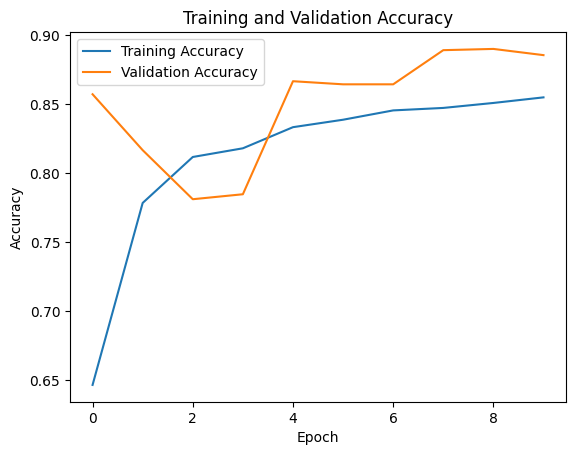

In [ ]:
import matplotlib.pyplot as plt

history = model.history
# Get the training and validation accuracy from the history object
train_accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']

# Plot the training and validation accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')

# Set the title and labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Show the plot
plt.legend()
plt.show()

### Testing


We used another data generator to test the accuracy of the model. This generator only uses 10% of our test dataset.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

test_datagen = ImageDataGenerator(
      rescale=1./255,
      validation_split=.0974
      #rotation_range=40,
      #width_shift_range=0.2,
      #height_shift_range=0.2,
      #shear_range=0.2,
      #zoom_range=0.2,
      #horizontal_flip=True,
      #fill_mode='nearest'
      )

test_generator = test_datagen.flow_from_directory(
        '/tmp/data/vehicle_data/data/test/',
        target_size=(96, 96),
        batch_size=32,
        subset='validation',
        class_mode='binary')

test_images=np.concatenate([test_generator.next()[0] for i in range(test_generator.__len__())])
test_labels=np.concatenate([test_generator.next()[1] for i in range(test_generator.__len__())])
print(test_images.shape)
print(test_labels.shape)

Found 864 images belonging to 2 classes.
(864, 96, 96, 3)
(864,)


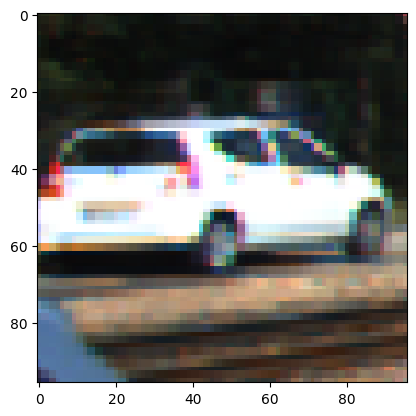

In [ ]:
plt.imshow(test_images[30])

In [ ]:
import math

predictions = model.predict_on_batch(test_images)
correct = 0

for i in range(len(predictions)):
  pred = predictions[i][0]
  if pred > 0.5:
    if math.ceil(pred) == test_labels[i]:
      correct += 1
  elif math.floor(pred) == test_labels[i]:
    correct += 1

print(f"Correct predictions: {correct} / {len(predictions)}")
print(f"Accuracy: {correct/len(predictions)}")

Correct predictions: 413 / 887
Accuracy: 0.46561443066516345


###Convert Model

The TFLiteConverter converts the saved tensorflow model into a light weight version that can be deployed on edge devices.

In [ ]:
#Converter quantization and optimized for size
import pathlib

converter = tf.lite.TFLiteConverter.from_saved_model(resnet50_saved_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_models_dir = pathlib.Path("/tmp/")
tflite_model = converter.convert()
tflite_model_file = tflite_models_dir/'resnet50_parksense.tflite'
tflite_model_file.write_bytes(tflite_model)

24106888

## MobileNet v2

Transfer learning was done with MobileNet v2, which is a 53 layer deep convolutional neural network.

In [ ]:
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.optimizers import RMSprop

MODULE_HANDLE ="https://tfhub.dev/google/imagenet/mobilenet_v2_035_96/feature_vector/5"
IMAGE_SHAPE = (96,96)

print("Using {} with input size {} ".format(MODULE_HANDLE, IMAGE_SHAPE))

base_model = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SHAPE + (3,),
                                   trainable=False)

print("Building model with", MODULE_HANDLE)

'''model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Flatten(),
        #tf.keras.layers.Dense(5, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
])'''
IMAGE_SIZE = (96,96)

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=IMAGE_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    #tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=['acc'])

Using https://tfhub.dev/google/imagenet/mobilenet_v2_035_96/feature_vector/5 with input size (96, 96) 
Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_035_96/feature_vector/5
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 47, 47, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 22, 22, 64)        0         
 ng2D)                                                           
                                                         

In [ ]:
history = model.fit(
      train_generator,
      epochs=5,
      validation_data=validation_generator)

Epoch 1/5
70/70 [==============================] - 43s 604ms/step - loss: 0.5300 - acc: 0.7748 - val_loss: 0.4112 - val_acc: 0.8874
Epoch 2/5
70/70 [==============================] - 40s 566ms/step - loss: 0.3492 - acc: 0.8716 - val_loss: 0.2784 - val_acc: 0.9252
Epoch 3/5
70/70 [==============================] - 45s 640ms/step - loss: 0.2676 - acc: 0.9045 - val_loss: 0.2092 - val_acc: 0.9518
Epoch 4/5
70/70 [==============================] - 43s 609ms/step - loss: 0.2130 - acc: 0.9347 - val_loss: 0.1689 - val_acc: 0.9518
Epoch 5/5
70/70 [==============================] - 45s 643ms/step - loss: 0.1910 - acc: 0.9401 - val_loss: 0.2249 - val_acc: 0.9117


In [ ]:
mobilenetv2_saved_model = "/content/drive/MyDrive/Colab Notebooks/ParkSense/models/custom_convs_saved_model"
tf.saved_model.save(model,mobilenetv2_saved_model)

### Training Accuracy

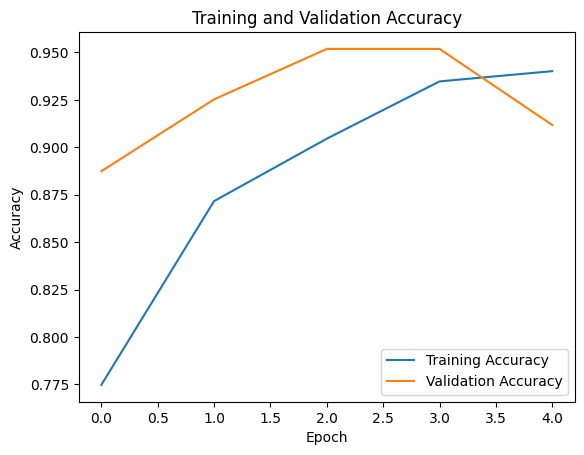

In [ ]:
import matplotlib.pyplot as plt

history = model.history
# Get the training and validation accuracy from the history object
train_accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']

# Plot the training and validation accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')

# Set the title and labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Show the plot
plt.legend()
plt.show()

### Testing


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

test_datagen = ImageDataGenerator(
      rescale=1./255,
      validation_split=.1
      #rotation_range=40,
      #width_shift_range=0.2,
      #height_shift_range=0.2,
      #shear_range=0.2,
      #zoom_range=0.2,
      #horizontal_flip=True,
      #fill_mode='nearest'
      )

test_generator = test_datagen.flow_from_directory(
        '/tmp/data/stanford_cars/cars_test/',
        target_size=(96, 96),
        batch_size=32,
        subset='validation',
        class_mode='binary')

test_images=np.concatenate([test_generator.next()[0] for i in range(test_generator.__len__())])
test_labels=np.concatenate([test_generator.next()[1] for i in range(test_generator.__len__())])
print(test_images.shape)
print(test_labels.shape)

Found 804 images belonging to 1 classes.
(804, 96, 96, 3)
(804,)


In [ ]:
plt.imshow(test_images[90])

In [ ]:
import math

predictions = model.predict_on_batch(test_images)
correct = 0

for i in range(len(predictions)):
  pred = predictions[i][0]
  #print(f"{i}, {pred}")
  if pred > 0.5:
    correct += 1
  # else:
  #   print(f"Incorrect: {i}")


print(f"Correct predictions: {correct} / {len(predictions)}")
print(f"Accuracy: {correct/len(predictions)}")

Correct predictions: 782 / 804
Accuracy: 0.972636815920398


### Convert Model

#### Convert with default Optimizations

In [ ]:
#Converter quantization and optimized for size
import pathlib

saved_model = "/content/drive/MyDrive/Colab Notebooks/ParkSense/models/custom_convs_saved_model"
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_models_dir = pathlib.Path("/tmp/")
tflite_model = converter.convert()
tflite_model_file = tflite_models_dir/'custom_convs_saved_model_defaultopt.tflite'
tflite_model_file.write_bytes(tflite_model)

150592

#### Convert with Int8 Quantizations

In [ ]:
test_dataset = tf.data.Dataset.from_generator(
    lambda: test_generator ,  # Our generator
    output_types = (tf.float32 , tf.float32) , # How we're expecting our output dtype
    output_shapes = ([32 , 96 , 96 , 3] , [32 , ]) # How we're expecting our output shape
)


converter.optimizations = [tf.lite.Optimize.DEFAULT]    # optimization

def representative_data_gen():                          # quantization from representative dataset
    for input_value, _ in test_dataset.take(100):
        yield [input_value]

converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

tflite_model = converter.convert()
tflite_models_dir = pathlib.Path("/content/")

tflite_model_file = tflite_models_dir/'custom_convs_saved_model_int8.tflite'
tflite_model_file.write_bytes(tflite_model)

274240

### Hexdump Model for Deployment

In [ ]:
! apt-get -qq install xxd
! xxd -i "/tmp/custom_convs_saved_model_defaultopt.tflite" > "./custom_convs_saved_model_defaultopt.cc"
! cat "./custom_convs_saved_model_defaultopt.cc"

### Testing with camera output


1/1 [==============================] - 0s 155ms/step
[0.01732383]

picture17.jpg is not a car!

1/1 [==============================] - 0s 47ms/step
[0.8389517]

picture12.jpg is a car!

1/1 [==============================] - 0s 47ms/step
[0.00994673]

picture16.jpg is not a car!

1/1 [==============================] - 0s 47ms/step
[0.06449902]

picture19.jpg is not a car!

1/1 [==============================] - 0s 58ms/step
[0.01440494]

picture13.jpg is not a car!

1/1 [==============================] - 0s 42ms/step
[0.02478938]

picture18.jpg is not a car!

1/1 [==============================] - 0s 44ms/step
[0.9282988]

picture20.jpg is a car!

1/1 [==============================] - 0s 43ms/step
[0.9115537]

picture14.jpg is a car!

1/1 [==============================] - 0s 51ms/step
[0.03447953]

picture15.jpg is not a car!

1/1 [==============================] - 0s 41ms/step
[0.01141597]

picture11.jpg is not a car!

1/1 [==============================] - 0s 31ms/step
[0.99546194]

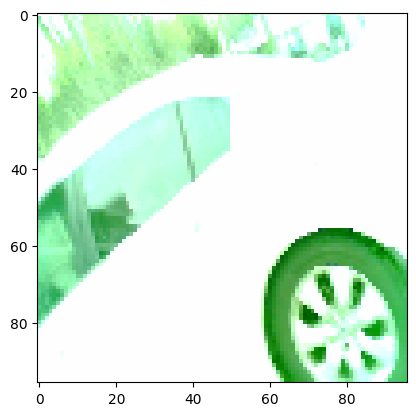

In [ ]:
import numpy as np
from google.colab import files
# from keras.preprocessing import image
import keras.utils as image
import os

PATH='/content/drive/MyDrive/Colab Notebooks/ParkSense/data/test_data/'
test_images = os.listdir(PATH)

for fi in test_images:  # predicting images
  path = PATH + fi
  img = image.load_img(path, target_size=(96,96))
  x = image.img_to_array(img)
  x = x / 255.0
  x = np.expand_dims(x, axis=0)

  plt.imshow(img)
  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  print(classes[0])
  print()
  if classes[0]>0.5:
    print(fi + " is a car!")
  else:
    print(fi + " is not a car!")
  print('')

#Our Own Model

##Training
#####We decided to trian our own model in the hopes of decreasing the total model size due to storage limitations

In [151]:
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.optimizers import RMSprop

IMAGE_SIZE = (96,96)

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=IMAGE_SIZE + (3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    #tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=['acc'])

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 47, 47, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 22, 22, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_24 (Flatten)        (None, 15488)             0         
                                                                 
 dense_47 (Dense)            (None, 4)               

Fit model to data using data generators

In [152]:
history = model.fit(
      train_generator,
      epochs=5,
      validation_data=validation_generator)

Epoch 1/5
70/70 [==============================] - 37s 517ms/step - loss: 0.5125 - acc: 0.8023 - val_loss: 0.4320 - val_acc: 0.8320
Epoch 2/5
70/70 [==============================] - 43s 618ms/step - loss: 0.3229 - acc: 0.8860 - val_loss: 0.2670 - val_acc: 0.9243
Epoch 3/5
70/70 [==============================] - 34s 487ms/step - loss: 0.2506 - acc: 0.9230 - val_loss: 0.2033 - val_acc: 0.9482
Epoch 4/5
70/70 [==============================] - 35s 499ms/step - loss: 0.2015 - acc: 0.9428 - val_loss: 0.1644 - val_acc: 0.9581
Epoch 5/5
70/70 [==============================] - 36s 514ms/step - loss: 0.1688 - acc: 0.9577 - val_loss: 0.1492 - val_acc: 0.9685


Save model

In [158]:
custom_saved_model = "/content/drive/MyDrive/Colab Notebooks/ParkSense/models/custom_convs_saved_model"
tf.saved_model.save(model,custom_saved_model)

Plot Accuracy

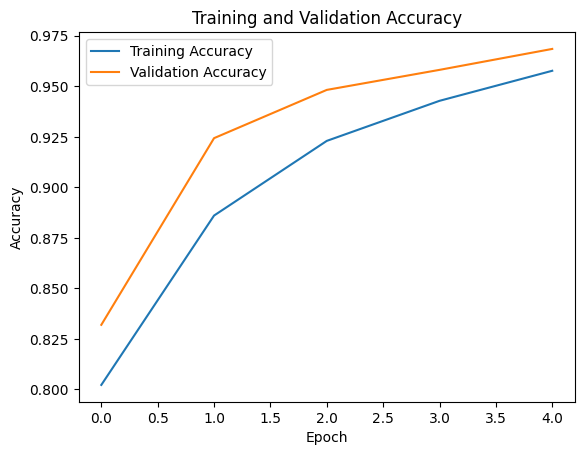

In [153]:
import matplotlib.pyplot as plt

history = model.history
# Get the training and validation accuracy from the history object
train_accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']

# Plot the training and validation accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')

# Set the title and labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Show the plot
plt.legend()
plt.show()

###Testing

In [154]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

test_datagen = ImageDataGenerator(
      rescale=1./255,
      validation_split=.1
      #rotation_range=40,
      #width_shift_range=0.2,
      #height_shift_range=0.2,
      #shear_range=0.2,
      #zoom_range=0.2,
      #horizontal_flip=True,
      #fill_mode='nearest'
      )

test_generator = test_datagen.flow_from_directory(
        '/tmp/data/stanford_cars/cars_test/',
        target_size=(96, 96),
        batch_size=32,
        subset='validation',
        class_mode='binary')

test_images=np.concatenate([test_generator.next()[0] for i in range(test_generator.__len__())])
test_labels=np.concatenate([test_generator.next()[1] for i in range(test_generator.__len__())])
print(test_images.shape)
print(test_labels.shape)

Found 804 images belonging to 1 classes.
(804, 96, 96, 3)
(804,)


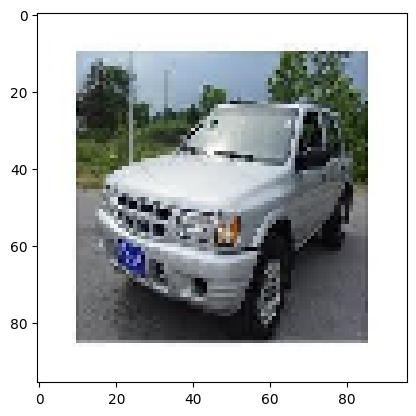

In [156]:
plt.imshow(test_images[90])

In [155]:
import math

predictions = model.predict_on_batch(test_images)
correct = 0

for i in range(len(predictions)):
  pred = predictions[i][0]
  #print(f"{i}, {pred}")
  if pred > 0.5:
    correct += 1
  # else:
  #   print(f"Incorrect: {i}")


print(f"Correct predictions: {correct} / {len(predictions)}")
print(f"Accuracy: {correct/len(predictions)}")

Correct predictions: 762 / 804
Accuracy: 0.9477611940298507


##Convert

In [159]:
#Converter quantization and optimized for size
import pathlib

saved_model = "/content/drive/MyDrive/Colab Notebooks/ParkSense/models/custom_convs_saved_model"
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_models_dir = pathlib.Path("/tmp/")
tflite_model = converter.convert()
tflite_model_file = tflite_models_dir/'custom_convs_saved_model_defaultopt.tflite'
tflite_model_file.write_bytes(tflite_model)

78944

###Optimize using int8

In [ ]:
test_dataset = tf.data.Dataset.from_generator(
    lambda: test_generator ,  # Our generator
    output_types = (tf.float32 , tf.float32) , # How we're expecting our output dtype
    output_shapes = ([32 , 96 , 96 , 3] , [32 , ]) # How we're expecting our output shape
)


converter.optimizations = [tf.lite.Optimize.DEFAULT]    # optimization

def representative_data_gen():                          # quantization from representative dataset
    for input_value, _ in test_dataset.take(100):
        yield [input_value]

converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

tflite_model = converter.convert()
tflite_models_dir = pathlib.Path("/content/")

tflite_model_file = tflite_models_dir/'custom_convs_saved_model_int8.tflite'
tflite_model_file.write_bytes(tflite_model)

###Hexdump model for deployement

In [160]:
! apt-get -qq install xxd
! xxd -i "/tmp/custom_convs_saved_model_defaultopt.tflite" > "./custom_convs_saved_model_defaultopt.cc"
! cat "./custom_convs_saved_model_defaultopt.cc"

unsigned char _tmp_custom_convs_saved_model_defaultopt_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x8c, 0x00, 0x00, 0x00, 0xe4, 0x00, 0x00, 0x00, 0x00, 0x27, 0x01, 0x00,
  0x10, 0x27, 0x01, 0x00, 0xb8, 0x33, 0x01, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x0a, 0xd8, 0xfe, 0xff,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x90, 0xff, 0xff, 0xff, 0x11, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00, 0x64, 0x65, 0x6e, 0x73,
  0x65, 0x5f, 0x34, 0x38, 0x00, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x92, 0xd9, 0xfe, 

1/1 [==============================] - 0s 80ms/step
[0.0047103]

picture17.jpg is not a car!

1/1 [==============================] - 0s 24ms/step
[0.5886961]

picture12.jpg is a car!

1/1 [==============================] - 0s 24ms/step
[0.00165774]

picture16.jpg is not a car!

1/1 [==============================] - 0s 26ms/step
[0.03761575]

picture19.jpg is not a car!

1/1 [==============================] - 0s 25ms/step
[0.00317147]

picture13.jpg is not a car!

1/1 [==============================] - 0s 24ms/step
[0.15745859]

picture18.jpg is not a car!

1/1 [==============================] - 0s 29ms/step
[0.90222603]

picture20.jpg is a car!

1/1 [==============================] - 0s 24ms/step
[0.81743705]

picture14.jpg is a car!

1/1 [==============================] - 0s 26ms/step
[0.01451194]

picture15.jpg is not a car!

1/1 [==============================] - 0s 31ms/step
[0.00300886]

picture11.jpg is not a car!

1/1 [==============================] - 0s 26ms/step
[0.99373245]

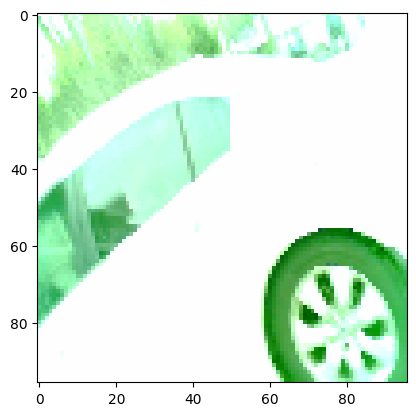

In [157]:
import numpy as np
from google.colab import files
# from keras.preprocessing import image
import keras.utils as image
import os

PATH='/content/drive/MyDrive/Colab Notebooks/ParkSense/data/test_data/'
test_images = os.listdir(PATH)

for fi in test_images:  # predicting images
  path = PATH + fi
  img = image.load_img(path, target_size=(96,96))
  x = image.img_to_array(img)
  x = x / 255.0
  x = np.expand_dims(x, axis=0)

  plt.imshow(img)
  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  print(classes[0])
  print()
  if classes[0]>0.5:
    print(fi + " is a car!")
  else:
    print(fi + " is not a car!")
  print('')